## <div align="center">Assignment for Module 3, CQF</div>
### <div align="right"><i>done by Sergei Beshenov,<br> Summer 2023 cohort</br></i></div>

### Task
Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$
$$
V(S, t)=e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}\left[\text { Payoff }\left(S_T\right)\right]
$$
for the appropriate form of payoff, to consider **asian** and **lookback** options.
Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data
$$
\begin{aligned}
\text { Today's stock price } S_0 & =100 \\
\text { Strike } E & =100 \\
\text { Time to expiry }(T-t) & =1 \text { year } \\
\text { volatility } \sigma & =20 \% \\
\text { constant risk-free interest rate } r & =5 \%
\end{aligned}
$$
Then vary the data to see the affect on the option price.

In [1]:
# libraries
import pandas as pd
from numpy import *

import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate

# plot params
plt.style.use("dark_background")
matplotlib.rcParams['figure.figsize'] = [8.0, 3.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 1.5

## Contents:
1. GBM simulation and proof of lognormal distribution
2. Asian and Lookback option pricing. Pricing of option European for comparison
3. Continuous vs Discrete monitoring
4. Put-call parity
5. Vary the data
6. Variance reduction technics
7. Monte-carlo sensitivities. Brief introduction
8. Conclusion
9. References 

### 1. GBM simulation and proof of lognormal distribution

As per CQF lectures and labs, we will simulate the asset price  $S_{t}$. Following Black-Scholes-Merton where the
underlying follows, under risk neutrality, a geometric Brownian motion with a stochastic differential
equation (SDE) is given as

$$ dS_{t} = rS_{t}dt + σS_{t}dW_{t} $$

where $S_{t}$ is the price of the underlying at time $t$, $σ$ is constant volatility, $r$ is the constant risk-free
interest rate and $W$ is the brownian motion.

Applying Euler-Maruyama discretization of SDE, we get

$$ S_{t+δt} = S_{t} ∗ (1 + rδt + σ\sqrt{δt}{}w_{t}) $$

The variable $w$ is a standard normally distributed random variable, $0 < δt < T$, time interval.

We have to note that the SDE has an exact solultion which is given below. It's convinient to use the solutions while pricing options with no path dependency, however, it's not our case.

$$ S_{t+δt} = S_{t}exp^{(r−\frac{1}{2}σ^{2})δt+σ\sqrt{δt}w_{t}} $$

Given that our goal is to price Asian and Lookback options we are going to implement Euler-Maruyama discretization scheme.

In [2]:
# define simulation function
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    # set the seed
    #random.seed(404)
    # read the params
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    # define dt
    dt = T/t
    # simulate path
    S = zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = random.standard_normal(n)
        S[i+1] = S[i] * (1+ r*dt + sigma*sqrt(dt)*w)
    return S

In [3]:
# Generate underlying asset paths
# mu = r, pricing under risk-neutral measure Q
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 100000] 
S = simulate_path(S0,mu,vol,T,t,n)
Spaths = pd.DataFrame(S)
Spaths.tail()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
247,81.616140,77.474573,94.964411,61.105957,78.580016,96.729440,71.802246,120.078568,102.299413,130.978304,...,102.422223,82.875374,110.645304,133.035408,139.422440,92.488673,142.428040,110.277284,162.765368,108.592639
248,84.084479,77.405701,93.334753,60.629307,80.535891,96.235935,71.615443,119.273461,103.847972,131.125703,...,104.589159,81.668053,108.678409,131.320723,138.038930,93.438309,140.099974,110.029924,164.823827,108.337035
249,84.315471,77.865657,96.373117,59.138999,81.156489,95.822201,71.590551,120.703884,103.151893,130.389789,...,103.505117,82.554152,108.436353,129.395916,137.094046,93.109868,139.544869,107.736699,165.270168,108.443079
250,84.602500,77.811607,95.099019,58.600594,81.767622,94.102535,73.528711,119.043590,101.966273,131.232042,...,104.714333,84.101150,107.127609,128.971510,138.614283,93.431178,139.975359,107.546115,164.831959,108.517877
251,84.837352,79.017801,95.618319,59.746531,80.812554,94.174568,72.989207,118.543240,102.086738,130.565505,...,104.038822,82.799118,108.110062,128.702109,139.568849,92.440644,137.084990,106.698840,165.763714,106.533713


### 1.1. Visualization of Simulated Paths

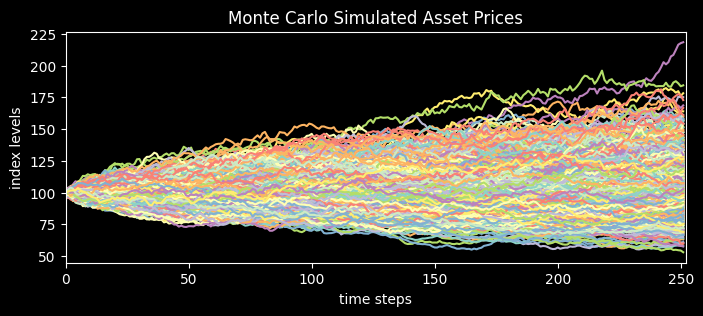

In [4]:
# Plot initial 1000 simulated path using matplotlib
plt.plot(Spaths.iloc[:,:1000])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Monte Carlo Simulated Asset Prices');


### 1.2 Histogram of Simulated Paths

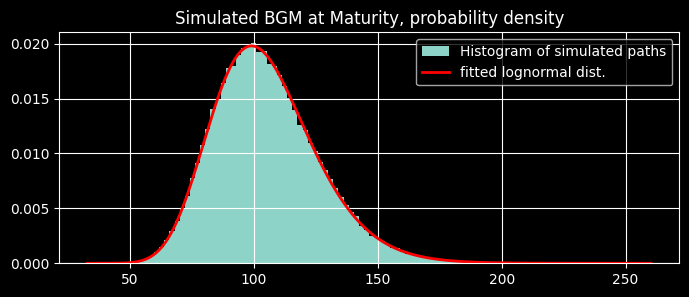

In [5]:
# Plot the histogram of the simulated price path at maturity
Spaths.iloc[-1].hist(bins=100, density=True, label = 'Histogram of simulated paths')
plt.title('Simulated BGM at Maturity, probability density')

# Let's see whether log normal distribution can be fitted to the simulated GBM paths
xmin, xmax = plt.xlim()
x = linspace(xmin, xmax, len(Spaths.iloc[-1]))
y, z, v = stats.lognorm.fit(Spaths.iloc[-1])
lognorm = stats.lognorm.pdf(x,y,z,v)

plt.plot(x, lognorm, 'r', linewidth = 2, label = 'fitted lognormal dist.')
plt.legend()
plt.show()

**Comment**: The first picture (from 1.1) gives us some visibility on MC simulation process. We see 1000 trajectories of a single stock that end up above the starting point (100) more often than below. 
The second picture shows the probability density distribution of 100000 outcomes at $S(T)$ and proves that the discretization method works: realised distribution possesses the right-skewed lognormal distribution characteristics.

## 2. Monte carlo option pricing

### 2.1 European option

It's always insightful to compare exotics to vanillas so the BS european option will be used for reference. 

In [6]:
class BS:
    """
    This is a class for Options contract for pricing European options on stocks, without dividends.
    Attributes:
    spot : int or float
    strike : int or float
    rate : float
    dte : int or float [days to expiration in number of years]
    volatility : float
    """
    def __init__(self, spot, strike, rate, dte, volatility, paths):
        
        # Spot Price
        self.spot = spot      
        # Simulated paths
        self.paths = paths
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Days To Expiration
        self.dte = dte
        # Volaitlity
        self.volatility = volatility
        # Utility
        self._a_ = self.volatility * self.dte**0.5

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_

            self._d2_ = self._d1_ - self._a_

            self._b_ = e**-(self.rate * self.dte)
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice']:
            self.__dict__[i] = None
            
            [self.callPrice, self.putPrice] = self._price()
            [self.callPriceMC, self.putPriceMC] = self._priceMC()

    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''
    
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * self.dte) * norm.cdf(self._d2_)
            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - self.spot * norm.cdf(-self._d1_)
        return [call, put]
    
     # Option MC Price
    def _priceMC(self):
        '''Returns the MC option price: [Call price, Put price]'''
    
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = e**(-self.rate * self.dte) * mean(maximum(self.paths[-1]-self.strike,0))
            put = e**(-self.rate * self.dte) * mean(maximum(self.strike-self.paths[-1],0))
        return [call, put]

In [7]:
# MC price vs Closed form solution for European option
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 1000000] 
S = simulate_path(S0,mu,vol,T,t,n)
E = 100 # strike
r = mu # risk free under Q
table1 = [['European Closed Form', BS(S0,E,r,T,vol,S).callPrice, BS(S0,E,r,T,vol,S).putPrice],
        ['European Monte Carlo', BS(S0,E,r,T,vol,S).callPriceMC, BS(S0,E,r,T,vol,S).putPriceMC]]
print(tabulate(table1, headers = ['Method','Call', 'Put'], tablefmt='orgtbl'))

| Method               |    Call |     Put |
|----------------------+---------+---------|
| European Closed Form | 10.4506 | 5.57353 |
| European Monte Carlo | 10.4082 | 5.56938 |


### 2.2 Asian option

**Asian options possess the strong type of path dependency**. Their payoffs depend on the average price of an underlying asset over a specific period, making them strongly path-dependent. This averaging feature helps lower the volatility associated with the option, as it reduces uncertainty resulting from fluctuations in the underlying asset price. Consequently, due to the reduced volatility, Asian options are expected to be priced lower compared to American or European options (let's compare these vs European options!).

The strike price of an Asian option is determined by aggregating the underlying asset prices throughout the option's duration. 

There are numerous permutations of Asian option; the most basic are listed below:

**Fixed strike (also known as an average rate) Asian call payout**

$$
C(T)=\max (A(0, T)-K, 0),
$$

where A denotes the average price for the period $[0, \mathrm{~T}]$, and $\mathrm{K}$ is the strike price. The equivalent put option is given by

$$
P(T)=\max (K-A(0, T), 0) .
$$

**The floating strike (or floating rate) Asian call option has the payout**

$$
C(T)=\max (S(T)-k A(0, T), 0),
$$

where $\mathrm{S}(\mathrm{T})$ is the price at maturity and $\mathrm{k}$ is a weighting, usually 1 so often omitted from descriptions. The equivalent put option payoff is given by

$$
P(T)=\max (k A(0, T)-S(T), 0) .
$$
**Types of averaging as well as descrete or continuous monitoring**

The Average $A$ may be obtained in many ways. Conventionally, this means an arithmetic average. In the continuous case, this is obtained by

$$
A(0, T)=\frac{1}{T} \int_0^T S(t) d t .
$$

For the case of discrete monitoring (with monitoring at the times $0=t_0, t_1, t_2, \ldots, t_n=T$ and $t_i=i \cdot \frac{T}{n}$ ) we have the average given by

$$
A(0, T)=\frac{1}{n} \sum_{i=1}^n S\left(t_i\right) .
$$

There also exist Asian options with geometric average; in the continuous case, this is given by

$$
A(0, T)=\exp \left(\frac{1}{T} \int_0^T \ln (S(t)) d t\right)
$$

And in descrete case, this is givern by 

$$A(0, T) = \exp \left({\frac{1}{n}\sum_{i=1}^{n}\ln S(t_i)}\right)$$

**Early excercise**

The last but not least feature to be considerd is an early exercise possibility. Asian options can expire either at maturity (and this is the most common type) or at any time in the life of the contract (american option style excersise).
Here and onwards we are going to condider european-like exercise only.

For further convergency analysis of MC estimates we define the closed form solution of Geometric Asian Fixed option given by:

$$d_1=\frac{log(S_0/K)+(T/2)(r+\sigma^2/6)}{\sigma\sqrt{T/3}} \quad \quad d_2=d_1-\sigma\sqrt{T/3}$$

$$Call_{geom} = S_0 e^{-(r+\sigma^2/6)(T/2)}N\,(d_1) - K e^{-rT}N\,(d_2)$$

$$Put_{geom} = K e^{-rT}N\,(-d_2) + S_0 e^{-(r+\sigma^2/6)(T/2)}N\,(-d_1) $$

In [8]:
class Asian:
    """
    This is a class for Asian contract for pricing options on stocks, without dividends.
    Attributes:
    spot : int or float
    strike : int or float
    rate : float
    dte : int or float [days to expiration in number of years]
    volatility : float
    """
    def __init__(self, spot, strike, rate, dte, volatility, paths):

            # Spot Price
            self.spot = spot
            # Option Strike
            self.strike = strike
            # Interest Rate
            self.rate = rate
            # Time To Maturity (in years)
            self.dte = dte
            # Volatility
            self.volatility = volatility
            # Monte Carlo Simulated underlying asset price S
            self.paths = paths

            if self.strike == 0:
                raise ZeroDivisionError('The strike price cannot be zero') # raise an exception
            else:
                self._d1_ = ((log(self.spot/self.strike) + 0.5*(self.rate+self.volatility**2/6)\
                              *self.dte)/(self.volatility * (self.dte/3) ** 0.5))
                self._d2_ = self._d1_ - self.volatility * (self.dte/3) ** 0.5        

            # __dict__ attribute
            for i in ['callGeomFixprice','putGeomFixprice','callGeomFixPriceMC', 'putGeomFixPriceMC', \
                     'callGeomFloatPriceMC','putGeomFloatPriceMC','callAFixPriceMC', 'putAFixPriceMC', \
                     'callAFloatPriceMC','putAFloatPriceMC','callAFixDeltaPW','putAFixDeltaPW']: 
                self.__dict__[i] = None
                
            [self.callAFixPriceMC, self.putAFixPriceMC] = self._AFixPriceMC()
            [self.callAFixDeltaPW, self.putAFixDeltaPW] = self._AFixDeltaPW()
            [self.callAFloatPriceMC, self.putAFloatPriceMC] = self._AFloatPriceMC()       
            [self.callGeomFixPrice, self.putGeomFixPrice] = self._GeomFixPrice()
            [self.callGeomFixPriceMC, self.putGeomFixPriceMC] = self._GeomFixPriceMC()
            [self.callGeomFloatPriceMC, self.putGeomFloatPriceMC] = self._GeomFloatPriceMC()
       
    def _AFixPriceMC(self): # Arithmetic Fixed MC
        avg = (self.paths).mean(axis=0)
        call = e**(-self.rate*self.dte) * mean(maximum(avg - self.strike, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(self.strike - avg, 0))
        return [call, put]
    
    def _AFixDeltaPW(self): # Arithmetic Fixed delta MC
        avg = (self.paths).mean(axis=0)
        dXTdX0 = avg/self.spot
        dVdXT_call = (avg>self.strike)
        dVdXT_put = (avg<self.strike)
        call_delta = mean(e**(-self.rate*self.dte)*dVdXT_call*dXTdX0)
        put_delta = mean(e**(-self.rate*self.dte)*dVdXT_put*dXTdX0)
        return [call_delta, put_delta]
    
    def _AFloatPriceMC(self): # Arithmetic Floating MC
        avg = (self.paths).mean(axis=0)
        call = e**(-self.rate*self.dte) * mean(maximum(self.paths[-1] - avg, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(avg - self.paths[-1], 0))
        return [call, put]

    # Black Scholes Asian Option Price (geom. averaging) from Paul's book
    def _GeomFixPrice(self): #  closed form solution for the geometric fixed asian option

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot*e**(-0.5*(self.rate + self.volatility**2/6)*self.dte)*\
            norm.cdf(self._d1_) - self.strike*e**(-self.rate*self.dte)*norm.cdf(self._d2_)
            put = self.strike*e**(-self.rate*self.dte)*norm.cdf(-self._d2_)\
            - self.spot*e**(-0.5*(self.rate + self.volatility**2/6)*self.dte)*norm.cdf(-self._d1_)
        return [call, put]

    def _GeomFixPriceMC(self): # Geometric Fixed MC
        avg = e**((log(self.paths)).mean(axis = 0))
        call = e**(-self.rate*self.dte) * mean(maximum(avg - self.strike, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(self.strike - avg, 0))
        return [call, put]

    def _GeomFloatPriceMC(self): # Geometric Floating MC
        avg = e**((log(self.paths)).mean(axis = 0))
        call = e**(-self.rate*self.dte) * mean(maximum(self.paths[-1] - avg, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(avg - self.paths[-1], 0))
        return [call, put]

In [9]:
# MC price vs Closed form solution for European option
table2 = [['Arithmetic Fixed Asian MC', Asian(S0,E,r,T,vol,S).callAFixPriceMC, Asian(S0,E,r,T,vol,S).putAFixPriceMC],
        ['Arithmetic Float Asian MC', Asian(S0,E,r,T,vol,S).callAFloatPriceMC, Asian(S0,E,r,T,vol,S).putAFloatPriceMC],
        ['Geom. Fixed Asian Closed form', Asian(S0,E,r,T,vol,S).callGeomFixPrice, Asian(S0,E,r,T,vol,S).putGeomFixPrice],
        ['Geom. Fixed Asian MC', Asian(S0,E,r,T,vol,S).callGeomFixPriceMC, Asian(S0,E,r,T,vol,S).putGeomFixPriceMC],
        ['Geom. Float Asian MC', Asian(S0,E,r,T,vol,S).callGeomFloatPriceMC, Asian(S0,E,r,T,vol,S).putGeomFloatPriceMC]]
print(tabulate(table2, headers = ['Method','Call', 'Put'], tablefmt='orgtbl'))

| Method                        |    Call |     Put |
|-------------------------------+---------+---------|
| Arithmetic Fixed Asian MC     | 5.7323  | 3.33929 |
| Arithmetic Float Asian MC     | 5.83717 | 3.39134 |
| Geom. Fixed Asian Closed form | 5.54682 | 3.46333 |
| Geom. Fixed Asian MC          | 5.51656 | 3.45798 |
| Geom. Float Asian MC          | 6.04555 | 3.26529 |


### 2.3. Lookback option

Lookback options are a type of exotic option with **strong path dependency**. The payoff depends on the optimal (maximum or minimum) underlying asset's price occurring over the life of the option. The option allows the holder to "look back" over time to determine the payoff. There exist two kinds of lookback options: with floating strike and with fixed strike.

**Lookback option with floating strike**

The payoff is the maximum difference between the market asset's price at maturity and the floating strike. For the call, the strike price is fixed at the asset's lowest price during the option's life, and, for the put, it is fixed at the asset's highest price. Worth to note that these options are not really options, as they will be always exercised by their holder. In fact, the option is never out-of-the-money, which makes it more expensive than a standard option. The payoff functions for the lookback call and the lookback put, respectively, are given by:

$$
L C_{\text {float }}=\max \left(S_T-S_{\min }, 0\right)=S_T-S_{\min }, \text { and } L P_{\text {float }}=\max \left(S_{\max }-S_T, 0\right)=S_{\max }-S_T,
$$

where $S_{\max }$ is the asset's maximum price during the life of the option, $S_{\min }$ is the asset's minimum price during the life of the option, and $S_T$ is the underlying asset's price at maturity $T$.

**Lookback option with fixed strike**

In this case, the option's strike price is fixed. The payoff is the difference between the maximum/minimum underlying asset price and the strike. The payoff functions for the lookback call and the lookback put, respectively, are given by:

$$
L C_{f i x}=\max \left(S_{\text {max }}-K, 0\right) \text {, and } L P_{f i x}=\max \left(K-S_{\text {min }}, 0\right),
$$

where $S_{\max }$ is the asset's maximum price during the life of the option, $S_{\min }$ is the asset's minimum price during the life of the option, and $K$ is the strike price.

**Early Excercise**

Lookback options can expire either at maturity (and this is the most common type) or at any time in the life of the contract (american option style excersise).
Here and onwards we are going to condider european-like exercise only.

**Discrete or continuous monitoring**

Same idea as for Asian option above.

In [10]:
class Lookback:
    """
    This is a class for Lookback option on stocks, without dividends.
    Attributes:
    spot : int or float
    strike : int or float
    rate : float
    dte : int or float [days to expiration in number of years]
    volatility : float
    """
    def __init__(self, spot, strike, rate, dte, vol, paths):
        
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Time to maturity (in years)
        self.dte = dte
        # vol
        self.vol = vol
        # Monte Carlo Simulated underlying asset price S
        self.paths = paths

        # __dict__ attribute
    
        for i in ['callFloatPriceMC','putFloatPriceMC','callFixPriceMC', 'putFixPriceMC']: 
            self.__dict__[i] = None

        [self.callFloatPriceMC, self.putFloatPriceMC] = self._FloatPriceMC()
        [self.callFixPriceMC, self.putFixPriceMC] = self._FixPriceMC()
    
    # MC Option Price    
    def _FixPriceMC(self): # Fixed Lookback Option MC
        minS = (self.paths).min(axis=0)
        maxS = (self.paths).max(axis=0)
        call = e**(-self.rate*self.dte) * mean(maximum(maxS - self.strike, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(self.strike - minS, 0))
        return [call, put]
    
    def _FloatPriceMC(self): # Floating Lookback Option MC
        minS = (self.paths).min(axis=0)
        maxS = (self.paths).max(axis=0)
        call = e**(-self.rate*self.dte) * mean(maximum(self.paths[-1] - minS, 0))
        put = e**(-self.rate*self.dte) * mean(maximum(maxS - self.paths[-1], 0))
        return [call, put]

In [11]:
table3 = [['Fixed Lookback MC', Lookback(S0,E,r,T,vol,S).callFixPriceMC, Lookback(S0,E,r,T,vol,S).putFixPriceMC],
        ['Float Loockback MC', Lookback(S0,E,r,T,vol,S).callFloatPriceMC, Lookback(S0,E,r,T,vol,S).putFloatPriceMC]]
    
print(tabulate(table3, headers = ['Method','Call', 'Put'], tablefmt='orgtbl'))

| Method             |    Call |     Put |
|--------------------+---------+---------|
| Fixed Lookback MC  | 18.2843 | 11.7335 |
| Float Loockback MC | 16.5723 | 13.4455 |


Now Let's compare all prices in one table:

In [12]:
print(tabulate(table1+ table2+table3, headers = ['Method','Call', 'Put'], tablefmt='orgtbl'))

| Method                        |     Call |      Put |
|-------------------------------+----------+----------|
| European Closed Form          | 10.4506  |  5.57353 |
| European Monte Carlo          | 10.4082  |  5.56938 |
| Arithmetic Fixed Asian MC     |  5.7323  |  3.33929 |
| Arithmetic Float Asian MC     |  5.83717 |  3.39134 |
| Geom. Fixed Asian Closed form |  5.54682 |  3.46333 |
| Geom. Fixed Asian MC          |  5.51656 |  3.45798 |
| Geom. Float Asian MC          |  6.04555 |  3.26529 |
| Fixed Lookback MC             | 18.2843  | 11.7335  |
| Float Loockback MC            | 16.5723  | 13.4455  |


**Comment**: It appeared that Lookback options are the most expensive followed by European options and then by Asian ones. Apparently, this is due to the possibility of ending up in the money. Asian options smoothen their price which lowers the volatility of their payoff, while Lookback options work with max and min of price, so the payoff will have the highest variance.


## 3. Continuous vs. discrete monitoring

Up to this moment, we only talked about continuous (~daily) Asian and Lookback options. This time, let us assume that prices are taken as per the end of each month only, starting from the time 0.

In [13]:
S = simulate_path(S0,mu,vol,T,t,n)
print(S.shape)
table_conti = [['Arithmetic Fixed Asian MC', Asian(S0,E,r,T,vol,S).callAFixPriceMC, Asian(S0,E,r,T,vol,S).putAFixPriceMC],
        ['Arithmetic Float Asian MC', Asian(S0,E,r,T,vol,S).callAFloatPriceMC, Asian(S0,E,r,T,vol,S).putAFloatPriceMC],
        ['Geom. Fixed Asian MC', Asian(S0,E,r,T,vol,S).callGeomFixPriceMC, Asian(S0,E,r,T,vol,S).putGeomFixPriceMC],
        ['Geom. Float Asian MC', Asian(S0,E,r,T,vol,S).callGeomFloatPriceMC, Asian(S0,E,r,T,vol,S[::]).putGeomFloatPriceMC],
        ['Fixed Lookback MC', Lookback(S0,E,r,T,vol,S).callFixPriceMC, Lookback(S0,E,r,T,vol,S).putFixPriceMC],
        ['Float Loockback MC', Lookback(S0,E,r,T,vol,S).callFloatPriceMC, Lookback(S0,E,r,T,vol,S).putFloatPriceMC]]


S = S[0::20]
print(S.shape)
table_discrete = [[Asian(S0,E,r,T,vol,S).callAFixPriceMC, Asian(S0,E,r,T,vol,S).putAFixPriceMC],
        [Asian(S0,E,r,T,vol,S).callAFloatPriceMC, Asian(S0,E,r,T,vol,S).putAFloatPriceMC],
        [Asian(S0,E,r,T,vol,S).callGeomFixPriceMC, Asian(S0,E,r,T,vol,S).putGeomFixPriceMC],
        [Asian(S0,E,r,T,vol,S).callGeomFloatPriceMC, Asian(S0,E,r,T,vol,S).putGeomFloatPriceMC],
        [Lookback(S0,E,r,T,vol,S).callFixPriceMC, Lookback(S0,E,r,T,vol,S).putFixPriceMC],
        [Lookback(S0,E,r,T,vol,S).callFloatPriceMC, Lookback(S0,E,r,T,vol,S).putFloatPriceMC]]


(252, 1000000)
(13, 1000000)


In [14]:
print(tabulate(concatenate([table_conti, table_discrete], axis=1), \
               headers = ['Method','Call cont.','Put cont.','Call discrete','Put discrete'], tablefmt='orgtbl'))

| Method                    |   Call cont. |   Put cont. |   Call discrete |   Put discrete |
|---------------------------+--------------+-------------+-----------------+----------------|
| Arithmetic Fixed Asian MC |      5.74252 |     3.33045 |         5.50637 |        3.19993 |
| Arithmetic Float Asian MC |      5.83413 |     3.40633 |         5.58545 |        3.26438 |
| Geom. Fixed Asian MC      |      5.52651 |     3.44917 |         5.28469 |        3.3215  |
| Geom. Float Asian MC      |      6.04242 |     3.27989 |         5.8002  |        3.13589 |
| Fixed Lookback MC         |     18.3046  |    11.7226  |        15.2828  |        9.61706 |
| Float Loockback MC        |     16.5625  |    13.4648  |        14.2446  |       10.6553  |


**Comment:** Monthly discrete monitoring gives us the following observations:
* Asian options tend to be more expensive while monitored discretely as less smoothing of prices is happening. So they tend to european prices as number of monitoring dates decreasing.
* Lookbacks options, in opposite, tend to cost less while monitored discretely. Lower price variance yelds lower option price as stock prices have less chances to reach their min and max at monitoring dates.

Please note that these observations hold only in above mentioned conditions. Vary conditions of descrete monitoring and results may change.

## 4. Put-call parity

**Now, let's check put-call parity of the option, to make sure that the pricing is consistent**


The call-put parity for **asian options** only exist for options with geometric averaging, developed by Kemna and Worst (1990) : 

$$AsianCall_{fix} - AsianPut_{fix} = S_0\exp^{\frac{-1}{2}(r+\frac{\sigma^2}{6})}- E\exp^{-r(T-t)}$$

The call-put parity relation for **lookback options**, developed by Wong and Kwok (2003):

$$LookbackCall_{fix}-LookbackPut_{floating} = S_0- Ee^{-rT}$$

In [15]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 1000000]
r = mu
E = 100
S = simulate_path(S0,r,vol,T,t,n)

print('left side of the equation: ',Asian(S0,E,r,T,vol,S).callGeomFixPriceMC-Asian(S0,E,r,T,vol,S).putGeomFixPriceMC)
print('right side of the equation: ',S0*e**(-1/2*(r+(vol**2)/6))-E*e**(-r*T))

left side of the equation:  2.0732212020359957
right side of the equation:  2.083486686050648


In [16]:
print('left side of the equation: ',Lookback(S0,E,r,T,vol,S).callFloatPriceMC-Lookback(S0,E,r,T,vol,S).putFixPriceMC)
print('right side of the equation: ',S0-E*e**(-r*T))

left side of the equation:  4.8564974179868
right side of the equation:  4.877057549928594


**Comment:** Parity holds.

## 5. Vary the data

**Now Let's play with parameters $S_0$, E, Vol, r, T and n - number of simulations**

### 5.1 Effect of $S_0$

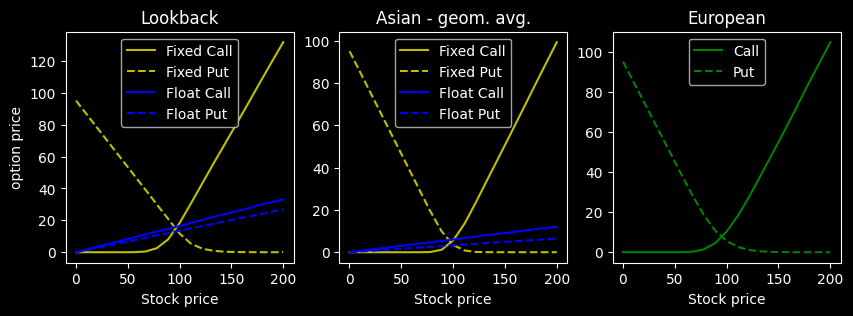

In [17]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 100000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

S0s = linspace(0.1, 200, 19)

for i in S0s:
    S = simulate_path(i,r,vol,T,t,n)
    LookbackFixCall.append(Lookback(i,E,r,T,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(i,E,r,T,vol,S).putFixPriceMC)
    LookbackFloatCall.append(Lookback(i,E,r,T,vol,S).callFloatPriceMC)
    LookbackFloatPut.append(Lookback(i,E,r,T,vol,S).putFloatPriceMC)
    
    AsianFixCall.append(Asian(i,E,r,T,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(i,E,r,T,vol,S).putGeomFixPriceMC)
    AsianFloatCall.append(Asian(i,E,r,T,vol,S).callGeomFloatPriceMC)
    AsianFloatPut.append(Asian(i,E,r,T,vol,S).putGeomFloatPriceMC)
    
    BSpriceCall.append(BS(i,E,r,T,vol,S).callPriceMC)
    BSpricePut.append(BS(i,E,r,T,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.plot(S0s, LookbackFixCall,"y-")
plt.plot(S0s, LookbackFixPut,"y--")
plt.plot(S0s, LookbackFloatCall,"b-")
plt.plot(S0s, LookbackFloatPut,"b--")
plt.xlabel("Stock price")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(132)
plt.plot(S0s, AsianFixCall,"y-")
plt.plot(S0s, AsianFixPut,"y--")
plt.plot(S0s, AsianFloatCall,"b-")
plt.plot(S0s, AsianFloatPut,"b--")
plt.xlabel("Stock price")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(133)
plt.plot(S0s, BSpriceCall,"g-")
plt.plot(S0s, BSpricePut,"g--")
plt.xlabel("Stock price")
plt.title('European')
plt.legend(['Call', 'Put'])

plt.show()

**Comment:** Varying $S0$ doesn't add much value here. Option contracts (Asian and LB) with floating strikes look like linear functions which makes sense given that strikes are dependent on stock price realization.

### 5.2 Effect of Strike (E)

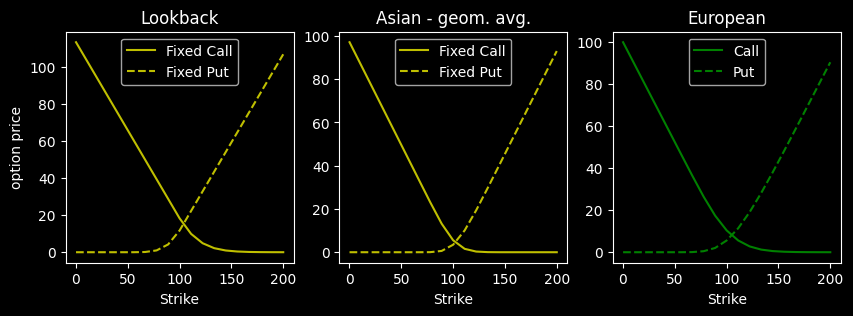

In [18]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []
AsianFixCall = []; AsianFixPut = []
BSpriceCall = []; BSpricePut = []

Strikes = linspace(0.1, 200, 19)
S = simulate_path(S0,r,vol,T,t,n)

for i in Strikes:
    LookbackFixCall.append(Lookback(S0,i,r,T,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(S0,i,r,T,vol,S).putFixPriceMC)

    AsianFixCall.append(Asian(S0,i,r,T,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(S0,i,r,T,vol,S).putGeomFixPriceMC)
    
    BSpriceCall.append(BS(S0,i,r,T,vol,S).callPriceMC)
    BSpricePut.append(BS(S0,i,r,T,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.plot(Strikes, LookbackFixCall,"y-")
plt.plot(Strikes, LookbackFixPut,"y--")
plt.xlabel("Strike")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put'])

plt.subplot(132)
plt.plot(Strikes, AsianFixCall,"y-")
plt.plot(Strikes, AsianFixPut,"y--")
plt.xlabel("Strike")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put'])

plt.subplot(133)
plt.plot(Strikes, BSpriceCall,"g-")
plt.plot(Strikes, BSpricePut,"g--")
plt.xlabel("Strike")
plt.title('European')
plt.legend(['Call','Put'])

plt.show()

**Comment:** Apparently, there is no effect from strike (E) for the floating type options as strike is determined by realization of Stock price.

All the options behave in a similar way: the higher the strike the lower the price for calls and vice versa for puts.

### 5.3 Effect of Volatility

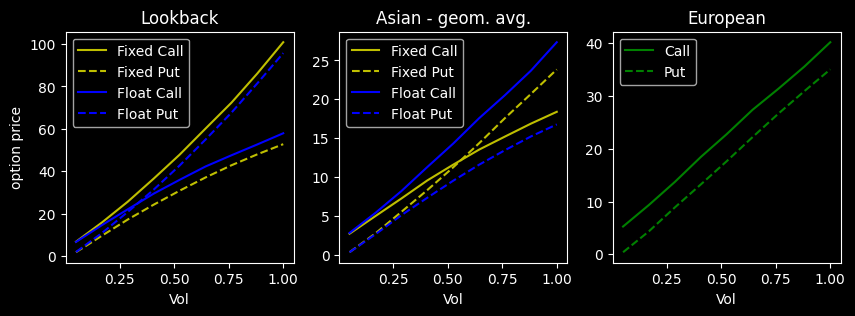

In [19]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 100000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

Vols = linspace(0.05, 1, 9)

for i in Vols:
    S = simulate_path(S0,r,i,T,t,n)
    LookbackFixCall.append(Lookback(S0,E,r,T,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(S0,E,r,T,vol,S).putFixPriceMC)
    LookbackFloatCall.append(Lookback(S0,E,r,T,vol,S).callFloatPriceMC)
    LookbackFloatPut.append(Lookback(S0,E,r,T,vol,S).putFloatPriceMC)
    
    AsianFixCall.append(Asian(S0,E,r,T,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(S0,E,r,T,vol,S).putGeomFixPriceMC)
    AsianFloatCall.append(Asian(S0,E,r,T,vol,S).callGeomFloatPriceMC)
    AsianFloatPut.append(Asian(S0,E,r,T,vol,S).putGeomFloatPriceMC)
    
    BSpriceCall.append(BS(S0,E,r,T,vol,S).callPriceMC)
    BSpricePut.append(BS(S0,E,r,T,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(Vols, LookbackFixCall,"y-")
plt.plot(Vols, LookbackFixPut,"y--")
plt.plot(Vols, LookbackFloatCall,"b-")
plt.plot(Vols, LookbackFloatPut,"b--")

plt.xlabel("Vol")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(132)
plt.plot(Vols, AsianFixCall,"y-")
plt.plot(Vols, AsianFixPut,"y--")
plt.plot(Vols, AsianFloatCall,"b-")
plt.plot(Vols, AsianFloatPut,"b--")
plt.xlabel("Vol")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(133)
plt.plot(Vols, BSpriceCall,"g-")
plt.plot(Vols, BSpricePut,"g--")
plt.xlabel("Vol")
plt.title('European')
plt.legend(['Call','Put'])


plt.show()

**Comment:** Option prices are positively correlated with the level of volatility. 
* For both Asian and Lookback options, call option with floating strike behaves similarly to put option with fixed strike, and vice versa. Very interesting finding, needs deeper research, which goes beyond this work.

### 5.4 Effect of time to maturity (T)

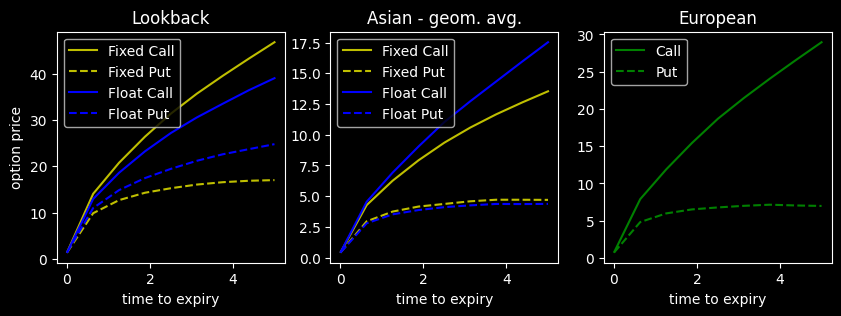

In [20]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 100000] 
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

timetoexp = linspace(0.01, 5, 9)

for i in timetoexp:
    S = simulate_path(S0,r,vol,i,t,n)
    LookbackFixCall.append(Lookback(S0,E,r,i,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(S0,E,r,i,vol,S).putFixPriceMC)
    LookbackFloatCall.append(Lookback(S0,E,r,i,vol,S).callFloatPriceMC)
    LookbackFloatPut.append(Lookback(S0,E,r,i,vol,S).putFloatPriceMC)
    
    AsianFixCall.append(Asian(S0,E,r,i,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(S0,E,r,i,vol,S).putGeomFixPriceMC)
    AsianFloatCall.append(Asian(S0,E,r,i,vol,S).callGeomFloatPriceMC)
    AsianFloatPut.append(Asian(S0,E,r,i,vol,S).putGeomFloatPriceMC)
    
    BSpriceCall.append(BS(S0,E,r,i,vol,S).callPriceMC)
    BSpricePut.append(BS(S0,E,r,i,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(timetoexp, LookbackFixCall,"y-")
plt.plot(timetoexp, LookbackFixPut,"y--")
plt.plot(timetoexp, LookbackFloatCall,"b-")
plt.plot(timetoexp, LookbackFloatPut,"b--")
plt.xlabel("time to expiry")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(132)
plt.plot(timetoexp, AsianFixCall,"y-")
plt.plot(timetoexp, AsianFixPut,"y--")
plt.plot(timetoexp, AsianFloatCall,"b-")
plt.plot(timetoexp, AsianFloatPut,"b--")
plt.xlabel("time to expiry")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(133)
plt.plot(timetoexp, BSpriceCall,"g-")
plt.plot(timetoexp, BSpricePut,"g--")
plt.xlabel("time to expiry")
plt.title('European')
plt.legend(['Call', 'Put'])

plt.show()

**Comment:** European, LB and Asian puts are less sensitive to maturity than calls. This can be explained by the fact of the logarithmic distribution of GBM and that stock price can't go negative. This is not news.

### 5.5 Effect of rate (r)

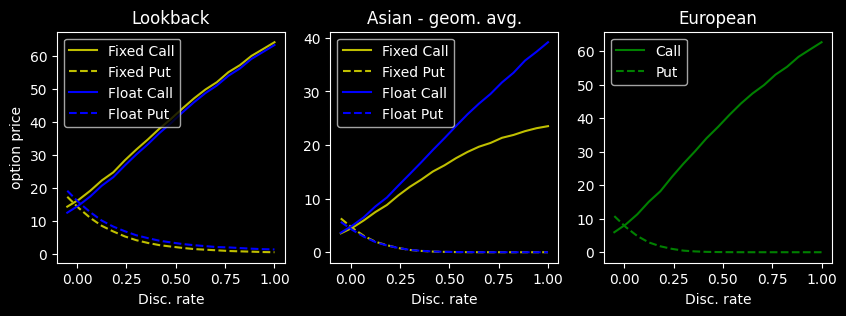

In [21]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

rates = linspace(-0.05, 1, 19)

for i in rates:
    S = simulate_path(S0,i,vol,T,t,n)
    LookbackFixCall.append(Lookback(S0,E,i,T,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(S0,E,i,T,vol,S).putFixPriceMC)
    LookbackFloatCall.append(Lookback(S0,E,i,T,vol,S).callFloatPriceMC)
    LookbackFloatPut.append(Lookback(S0,E,i,T,vol,S).putFloatPriceMC)
    
    AsianFixCall.append(Asian(S0,E,i,T,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(S0,E,i,T,vol,S).putGeomFixPriceMC)
    AsianFloatCall.append(Asian(S0,E,i,T,vol,S).callGeomFloatPriceMC)
    AsianFloatPut.append(Asian(S0,E,i,T,vol,S).putGeomFloatPriceMC)
    
    BSpriceCall.append(BS(S0,E,i,T,vol,S).callPriceMC)
    BSpricePut.append(BS(S0,E,i,T,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(rates, LookbackFixCall,"y-")
plt.plot(rates, LookbackFixPut,"y--")
plt.plot(rates, LookbackFloatCall,"b-")
plt.plot(rates, LookbackFloatPut,"b--")
plt.xlabel("Disc. rate")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(132)
plt.plot(rates, AsianFixCall,"y-")
plt.plot(rates, AsianFixPut,"y--")
plt.plot(rates, AsianFloatCall,"b-")
plt.plot(rates, AsianFloatPut,"b--")
plt.xlabel("Disc. rate")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'])

plt.subplot(133)
plt.plot(rates, BSpriceCall,"g-")
plt.plot(rates, BSpricePut,"g--")
plt.xlabel("Disc. rate")
plt.title('European')
plt.legend(['Call', 'Put'])

plt.show()

**Comment:** Sensitivity to rates is obvious, the higher the rate the more expensive is call and the less expensive is put.

### 5.6.1 Effect of num. of simulations 

#### 5.6.1 Effect of num. of simulations (price stabilization / convergency)

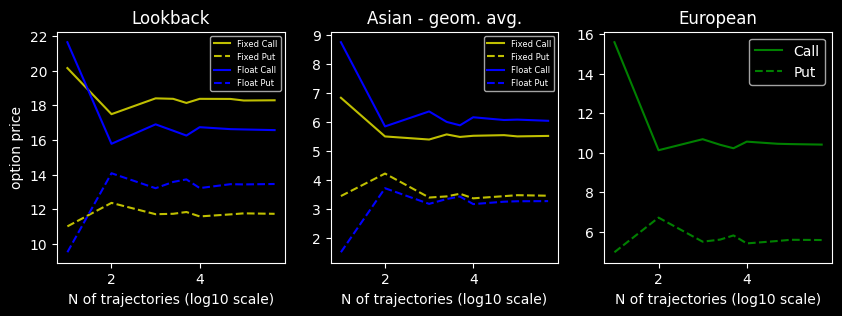

In [22]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

N = [10,100,1000,2500,5000,10000,50000,100000,500000]

for i in N:
    S = simulate_path(S0,r,vol,T,t,i)
    LookbackFixCall.append(Lookback(S0,E,r,T,vol,S).callFixPriceMC)
    LookbackFixPut.append(Lookback(S0,E,r,T,vol,S).putFixPriceMC)
    LookbackFloatCall.append(Lookback(S0,E,r,T,vol,S).callFloatPriceMC)
    LookbackFloatPut.append(Lookback(S0,E,r,T,vol,S).putFloatPriceMC)
    
    AsianFixCall.append(Asian(S0,E,r,T,vol,S).callGeomFixPriceMC)
    AsianFixPut.append(Asian(S0,E,r,T,vol,S).putGeomFixPriceMC)
    AsianFloatCall.append(Asian(S0,E,r,T,vol,S).callGeomFloatPriceMC)
    AsianFloatPut.append(Asian(S0,E,r,T,vol,S).putGeomFloatPriceMC)
    
    BSpriceCall.append(BS(S0,E,r,T,vol,S).callPriceMC)
    BSpricePut.append(BS(S0,E,r,T,vol,S).putPriceMC)
    
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(log10(N), LookbackFixCall,"y-")
plt.plot(log10(N), LookbackFixPut,"y--")
plt.plot(log10(N), LookbackFloatCall,"b-")
plt.plot(log10(N), LookbackFloatPut,"b--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('Lookback')
plt.ylabel('option price')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'], prop={'size': 6})

plt.subplot(132)
plt.plot(log10(N), AsianFixCall,"y-")
plt.plot(log10(N), AsianFixPut,"y--")
plt.plot(log10(N), AsianFloatCall,"b-")
plt.plot(log10(N), AsianFloatPut,"b--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'],prop={'size': 6})

plt.subplot(133)
plt.plot(log10(N), BSpriceCall,"g-")
plt.plot(log10(N), BSpricePut,"g--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('European')
plt.legend(['Call', 'Put'])

plt.show()

**Comment:** Prices stabilize at ~10^4-10^5 num of simulations, this is a minimum to get a satisfactory precision.

#### 5.6.2 Effect of num. of simulations (standard deviation of estimated prices)

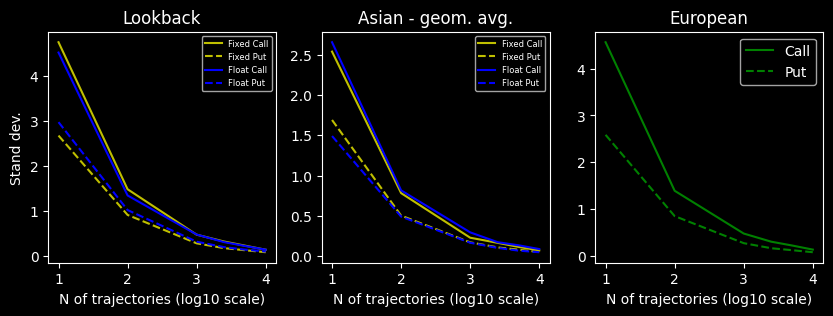

In [23]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
LookbackFixCall = []; LookbackFixPut = []; LookbackFloatCall = []; LookbackFloatPut = [];
AsianFixCall = []; AsianFixPut = []; AsianFloatCall = []; AsianFloatPut = [];
BSpriceCall = []; BSpricePut = []

N = [10,100,1000,2500, 5000, 10000]

for i in N:
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)]
    
    LookbackFixCall.append(std([Lookback(S0,E,r,T,vol,_).callFixPriceMC for _ in S]))
    LookbackFixPut.append(std([Lookback(S0,E,r,T,vol,_).putFixPriceMC for _ in S]))
    LookbackFloatCall.append(std([Lookback(S0,E,r,T,vol,_).callFloatPriceMC for _ in S]))
    LookbackFloatPut.append(std([Lookback(S0,E,r,T,vol,_).putFloatPriceMC for _ in S]))
    
    AsianFixCall.append(std([Asian(S0,E,r,T,vol,_).callGeomFixPriceMC for _ in S]))
    AsianFixPut.append(std([Asian(S0,E,r,T,vol,_).putGeomFixPriceMC for _ in S]))
    AsianFloatCall.append(std([Asian(S0,E,r,T,vol,_).callGeomFloatPriceMC for _ in S]))
    AsianFloatPut.append(std([Asian(S0,E,r,T,vol,_).putGeomFloatPriceMC for _ in S]))
    
    BSpriceCall.append(std([BS(S0,E,r,T,vol,_).callPriceMC for _ in S]))
    BSpricePut.append(std([BS(S0,E,r,T,vol,_).putPriceMC for _ in S]))
        
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(log10(N), LookbackFixCall,"y-")
plt.plot(log10(N), LookbackFixPut,"y--")
plt.plot(log10(N), LookbackFloatCall,"b-")
plt.plot(log10(N), LookbackFloatPut,"b--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('Lookback')
plt.ylabel('Stand dev.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'], prop={'size': 6})

plt.subplot(132)
plt.plot(log10(N), AsianFixCall,"y-")
plt.plot(log10(N), AsianFixPut,"y--")
plt.plot(log10(N), AsianFloatCall,"b-")
plt.plot(log10(N), AsianFloatPut,"b--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('Asian - geom. avg.')
plt.legend(['Fixed Call','Fixed Put', 'Float Call', 'Float Put'],prop={'size': 6})

plt.subplot(133)
plt.plot(log10(N), BSpriceCall,"g-")
plt.plot(log10(N), BSpricePut,"g--")
plt.xlabel("N of trajectories (log10 scale)")
plt.title('European')
plt.legend(['Call', 'Put'])

plt.show()

**Comment:** Again, by conducting 100 estimations of price at every level of N (number of simulation), and then taking of standard deviation of these estimates we come to the same conclusion as above. Prices stabilize at around 10^4 num of simulations, this is a minimum to get satisfactory precision.

#### 5.6.3 Effect of num. of simulations (RMSE)
Now, let us RMSE  for difference between Closed form and monte-carlo to make sure that our price is converging to a true one. Given that earlier we added code for closed form solution of geom. asian fixed option, let us do some comparison

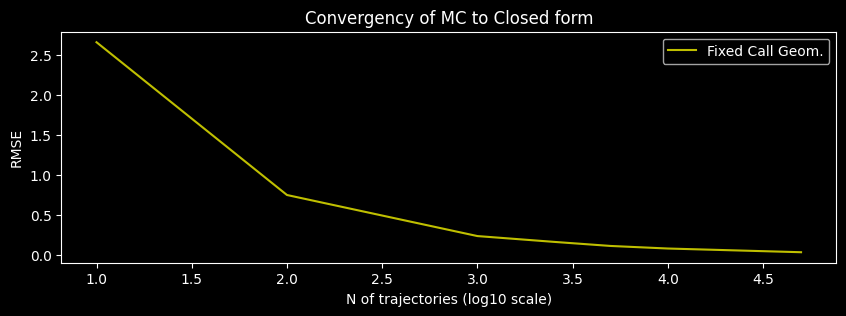

In [24]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
S = simulate_path(S0,r,vol,T,t,n)
     
AsianFixCall = [];

N = [10,100,1000,2500, 5000, 10000, 50000]

call = Asian(S0,E,r,T,vol,S).callGeomFixPrice

for i in N:
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)]
    
    AsianFixCall.append(std([Asian(S0,E,r,T,vol,_).callGeomFixPriceMC-call for _ in S]))

fig = plt.figure(figsize=(10, 3))

plt.plot(log10(N), AsianFixCall,"y-")

plt.xlabel("N of trajectories (log10 scale)")
plt.title('Convergency of MC to Closed form')
plt.ylabel('RMSE')
plt.legend(['Fixed Call Geom.'])

**Comment:** Now, by conducting 100 estimations of price errors (MC price - true price) at every level of N (number of simulation), and then taking the standard deviations of these estimates we come to the same conclusion as above. The more trajectories we use the better is accuracy of estimated prices

## 6. Variance reduction technics 
Variance reduction methods in Monte Carlo simulations are techniques used to improve efficiency and reduce uncertainty in the results. By minimizing the variability of estimates, these methods make better use of random samples and reduce the need for large sample sizes. Some common variance reduction techniques include antithetic sampling, control variates, stratified sampling, importance sampling and pseudo monte carlo. These methods help to increase the accuracy and precision of Monte Carlo simulations, making them more reliable in various applications.


### Antithetic Variates
Appoach: Normal random variables $\omega_k$ have a symmetric density. Let's force the distribution to be symmetric: let $\omega_{2k+1} = -\omega_{2k}$. Only half of the variables will be truly random. The other half will guarantee that the distribution be symmetric.

### Control Variates

The price $E[f(X)]$ will not be exactly replicated due to statistical discrepancies. Let's assess these discrepancies.
* Let the expected value $E_0 = E[g(X_T)]$ be known (i.e. it is usually known for $g(x)=x$). $G = g(X_T)$ is called a *control variate* for $F = f(X_T)$.
* In theory the following quantity has zero expected value:
$$
d = \left(\frac1N\sum_{i=1}^{N}g(X_T^{(i)})\right) - E[g(X_T)];\quad E(d) = 0
$$
* Then $E[f(X)] = E\left[f(X) - k\cdot d\right]$ for any $k$.
* Choose $k$ to minimize the variance.

If $G$ is used as a control variable for $F$, then $k_{opt}=\dfrac{Cov[F,G]}{Var[G]}$, and the minimum attainable variance is $Var[F](1-\rho^2)$, where $\rho$ is the correlation between $F$ and $G$.

### Milstein Discretization method (not a variance reduction method but worth for comparison

Same as Euler method, but Taylor expansion is taken up to the second order:
$$S_{t+\delta t} \sim S_t \; \left(1 + r\delta t + \sigma \omega \sqrt{\delta t}+\frac{1}{2}\sigma^2(\omega^2-1)\delta t\right)$$

In [25]:
def simulate_path_antithetic(s0, mu, sigma, horizon, timesteps, n_sims):
    # set the seed
    #random.seed(404)
    # read the params
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    # define dt
    dt = T/t
    # simulate path
    S = zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = random.standard_normal(n//2)
        w = concatenate((w,-w), axis = 0)
        S[i+1] = S[i] * (1+ r*dt + sigma*sqrt(dt)*w)
    return S

In [26]:
def simulate_path_milstein(s0, mu, sigma, horizon, timesteps, n_sims):
        # set the seed
    #random.seed(404)
    # read the params
    S0 = s0
    r = mu
    T = horizon
    t = timesteps
    n = n_sims
    # define dt
    dt = T/t
    # simulate path
    S = zeros((t,n))
    S[0] = S0
    for i in range(0, t-1):
        w = random.standard_normal(n)
        S[i+1] = S[i] * (1+r*dt+sigma*sqrt(dt)*w + 1/2*sigma**2*(w**2-1)*dt)
    return S

In [27]:
def ControlVariateAsianGeomCall(S0,E,r,T,vol,S): # control variate BS price for Asian geom. fixed option 
    # F - exoctic MC prices
    # G - vanilla MC prices
    # EG - closed form vanilla price
    avg = e**((log(S)).mean(axis = 0))
    F = e**(-r*T) * maximum(avg - E, 0)
    
    G = e**(-r*T) * maximum(S[-1]-E,0)
    k = corrcoef(F,G)[0,1]*std(F)/std(G)
    EG = BS(S0,E,r,T,vol,S).callPrice
    return mean(F - k*(G-EG))

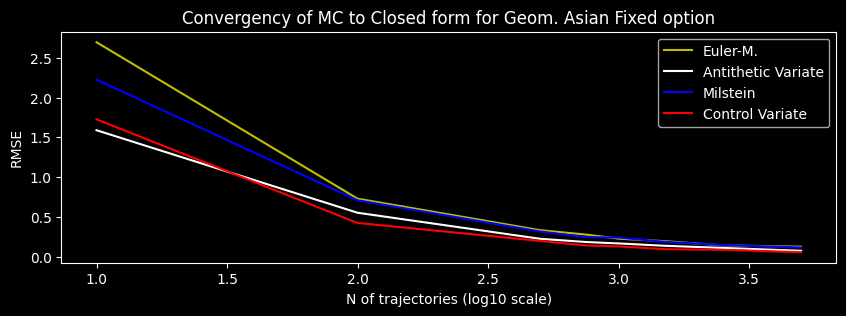

In [28]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
S = simulate_path(S0,r,vol,T,t,n)
     
AsianFixCall0 = []; AsianFixCall1 = []; AsianFixCall2 = []; AsianFixCall3 = []

N = [10,100,500,750,1000,1500,2500,5000]# 10000]

call = Asian(S0,E,r,T,vol,S).callGeomFixPrice

for i in N:
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)] 
    AsianFixCall0.append(std([Asian(S0,E,r,T,vol,_).callGeomFixPriceMC-call for _ in S]))
    
for i in N:
    S = [simulate_path_antithetic(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCall1.append(std([Asian(S0,E,r,T,vol,_).callGeomFixPriceMC-call for _ in S]))
    
for i in N:
    S = [simulate_path_milstein(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCall2.append(std([Asian(S0,E,r,T,vol,_).callGeomFixPriceMC-call for _ in S]))
    
for i in N:    
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCall3.append(std([ControlVariateAsianGeomCall(S0,E,r,T,vol,_)-call for _ in S]))
    
fig = plt.figure(figsize=(10, 3))

plt.plot(log10(N), AsianFixCall0,"y-")
plt.plot(log10(N), AsianFixCall1,"w-")
plt.plot(log10(N), AsianFixCall2,"b-")
plt.plot(log10(N), AsianFixCall3,"r-")

plt.xlabel("N of trajectories (log10 scale)")
plt.title('Convergency of MC to Closed form for Geom. Asian Fixed option')
plt.ylabel('RMSE')
plt.legend(['Euler-M.','Antithetic Variate','Milstein','Control Variate'])

**Comment:** Antithetic variate and control variate methods proved to converge faster than basic discretization schemes with no variance reduction applied

#### Now, let's try to price asian arithmetic option by using geometric asian option as a control variate

In [29]:
def ControlVariateAsianArithmeticCall(S0,E,r,T,vol,S):
    # F - exoctic MC prices
    # G - vanilla MC prices
    # EG - closed form vanilla price
    avg_geom = e**((log(S)).mean(axis = 0))
    avg_arith = S.mean(axis = 0)
    F = e**(-r*T) * maximum(avg_arith - E, 0)
    
    G = e**(-r*T) * maximum(avg_geom - E, 0)
    k = corrcoef(F,G)[0,1]*std(F)/std(G)
    EG = Asian(S0,E,r,T,vol,S).callGeomFixPrice
    return mean(F - k*(G-EG))

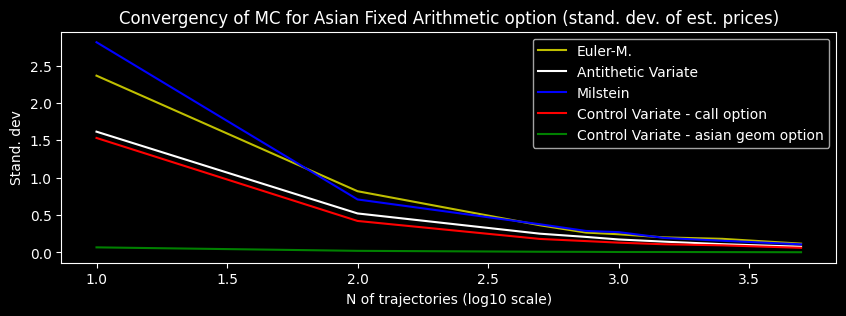

In [30]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
S = simulate_path(S0,r,vol,T,t,n)
     
AsianFixCall0 = []
AsianFixCall1 = []
AsianFixCall2 = []
AsianFixCall3 = []
AsianFixCall4 = []

N = [10,100,500,750,1000,1500,2500, 5000]# 10000]

call = Asian(S0,E,r,T,vol,S).callGeomFixPrice

for i in N:
    S = [simulate_path_antithetic(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCall1.append(std([Asian(S0,E,r,T,vol,_).callAFixPriceMC for _ in S]))
    S = [simulate_path_milstein(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCall2.append(std([Asian(S0,E,r,T,vol,_).callAFixPriceMC for _ in S]))
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)] 
    AsianFixCall0.append(std([Asian(S0,E,r,T,vol,_).callAFixPriceMC for _ in S]))
    AsianFixCall3.append(std([ControlVariateAsianGeomCall(S0,E,r,T,vol,_) for _ in S]))
    AsianFixCall4.append(std([ControlVariateAsianArithmeticCall(S0,E,r,T,vol,_) for _ in S]))    
    

fig = plt.figure(figsize=(10, 3))

plt.plot(log10(N), AsianFixCall0,"y-")
plt.plot(log10(N), AsianFixCall1,"w-")
plt.plot(log10(N), AsianFixCall2,"b-")
plt.plot(log10(N), AsianFixCall3,"r-")
plt.plot(log10(N), AsianFixCall4,"g-")

plt.xlabel("N of trajectories (log10 scale)")
plt.title('Convergency of MC for Asian Fixed Arithmetic option (stand. dev. of est. prices)')
plt.ylabel('Stand. dev')
plt.legend(['Euler-M.','Antithetic Variate','Milstein','Control Variate - call option','Control Variate - asian geom option'])

**Comment:** Use of Closed form solution for Geom. Asian (Fixed strike) option as a control variate is game changer for pricing Arithmetic Asian option. Here, we calculate stand. deviation for 100 esimations of prices for different N of trajectories. 

## 7. Monte Carlo sensitivities


#### Finite difference approximation

Within MC framework, FD approximation is computationally expensive (see P. Glasserman) so we are not going look into it this time. Instead, we focus on Pathwse differentiation and Likilifood ration method which are commonly used in practice.

#### Pathwise differentiation
Under _certain conditions_ (the interchange of differentiation and expectation shall be justified as per Paul Glasserman's book),
$$
\dfrac{\partial E[V]}{\partial \theta}=E\left[\dfrac{\partial V}{\partial \theta}\right]
$$
Then for *vanilla* call option, $\Delta$ is:
$$
\dfrac{\partial V}{\partial S_0}=\dfrac{\partial V}{\partial S_T}\cdot \dfrac{\partial S_T}{\partial S_0}
$$
Note that since $ S_{t+δt} = S_{t} ∗ (1 + rδt + σ\sqrt{δt}{}w_{t}) $, we have
$$
\dfrac{\partial S_T}{\partial S_0} = \dfrac{S_T}{S_0}
$$
while for *asian options* (see P. Glasserman), $\Delta$ is given by:
$$
\dfrac{\partial A_{(0,T)}}{\partial S_0} = \dfrac{A_{(0,T)}}{S_0}
$$

#### Likelihood ratio method

$$
\dfrac{\partial E[V]}{\partial \theta}=\int V(x)\frac{\partial\rho_\theta(x)}{\partial \theta}dx=
\int V(x)\frac{\dot{\rho}_\theta(x)}{\rho_\theta(x)}\rho_\theta(x)dx=E\left[V(x)\frac{\dot{\rho}_\theta(x)}{\rho_\theta(x)}\right]=E\left[V(x)\frac{\partial\log \rho_\theta(x)}{\partial\theta}\right]
$$
Does not depend on $V$! Can use it with any payoff function without any modification

In [31]:
def DeltaAsianCallLR(S0, E, r, sigma, T, t, n):
    S = zeros((t,n))
    z = zeros(n)
    dt = T/t
    S[0] = S0
    for i in range(0, t-1):
        w = random.standard_normal(n)
        S[i+1] = S[i] * (1+ r*dt + vol*sqrt(dt)*w)
        if i == 0:
            z = w
    avg = mean(S, axis = 0)
    LR = z/(vol*sqrt(dt)*S0)
    V = e**(-r*T)*maximum(avg-E,0)
    return mean(V*LR)

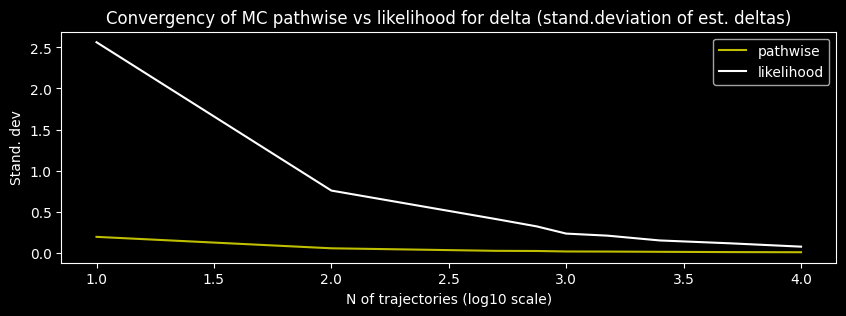

In [32]:
S0, mu, vol, T, t, n = [100, 0.05, 0.2, 1, 252, 10000]
E = 100
r = mu
S = simulate_path(S0,r,vol,T,t,n)
     
AsianFixCalldeltaPW = []
AsianFixCalldeltaLR = []

N = [10, 100,500,750,1000,1500, 2500, 5000,10000]# 10000]

for i in N:
    S = [simulate_path(S0,r,vol,T,t,i) for m in range(0,100)]
    AsianFixCalldeltaPW.append(std([Asian(S0,E,r,T,vol,_).callAFixDeltaPW for _ in S]))
    AsianFixCalldeltaLR.append(std([DeltaAsianCallLR(S0,E,r,vol,T,t,i) for m in range(0,100)]))
    
fig = plt.figure(figsize=(10, 3))

plt.plot(log10(N), AsianFixCalldeltaPW,"y-")
plt.plot(log10(N), AsianFixCalldeltaLR,"w-")

plt.xlabel("N of trajectories (log10 scale)")
plt.title('Convergency of MC pathwise vs likelihood for delta (stand.deviation of est. deltas)')
plt.ylabel('Stand. dev')
plt.legend(['pathwise','likelihood'])

Pathwise MC calculation for delta converges from the small num of trajectories, while likelihood method seems to be not working well for options with strong path-dependency.

In [33]:
S = simulate_path(S0,r,vol,T,t,n)
print('An example of calculated deltas for n = 10000:')
print('Asian Fixed Call (arithmetic) delta PW: ', Asian(S0,E,r,T,vol,S).callAFixDeltaPW)
print('Asian Fixed Call (arithmetic) delta LR: ', DeltaAsianCallLR(S0,E,r,vol,T,t,n))

An example of calculated deltas for n = 10000:
Asian Fixed Call (arithmetic) delta PW:  0.5845324115979967
Asian Fixed Call (arithmetic) delta LR:  0.615058903267684


## 8. Conclusion

Please find the recap of comments and observations from the above workings:
1. Lookback options are the most expensive followed by European options and then by Asian ones. Apparently, this is due to the possibility of ending up in the money. Asian options smoothen their price which lowers the volatility of their payoff, while Lookback options work with max and min of price, so the payoff will have the highest variance.
2. Asian fixed strike options tend to be more expensive while monitored discretely. In opposite, lookback options tend to be cheaper while monitored discretely.
3. Call-put parities for Asian and LB options exist and hold.
4. Option prices are positively correlated with the level of volatility. For both Asian and Lookback options, call option with floating strike behaves similarly to put option with fixed strike wrt to change in volatility, and vice versa. It is a very interesting finding and needs deeper research, which goes beyond this work.
5. Good convergency of MC method for LB and Asian options ATM is expected at level of 10 000 trajectories. The rule of thumb: The more the better. For OTM options, an additional research may be required.
6. Variance reduction technics work! Control variates and antithetic variates outperform basic simulation with Euler or Milstein schemes
7. Use of Closed form solution for Geom. Asian (Fixed strike) option as a control variate is game changer for pricing Arithmetic Asian option.
8. Pathwise MC calculation for delta converges nicely, while likelihood method seems to be not working well for options with strong path-dependency.


## 9. Reference list

CQF sources:
1. CQF Module 3 Lecture 4: Introduction to Numerical methods
2. CQF Module 3 Lecture 5: Exotic Options
3. CQF Module 3 Lecture 6: Further Numerical Methods
4. CQF Python primers
5. CQF Python lab: Black Scholes option pricing
6. CQF Python lab: Monte Carlo simulation
7. Paul Wilmott on Quantitative Finance, second edition
8. Paul Wilmott introduces Quantitative Finance, second edition
9. Monte Carlo methods in finance, Peter Jäckel

Other sources:

10. Glasserman, Paul. Monte Carlo methods in financial engineering. Vol. 53. New York: springer, 2004.
11. Kemna, A.G.Z., Vorst, A.C.F.,  A pricing method for options based on average asset values. Journal of Banking & Finance 14, 1990, 113–1
12. H. Y. Wong and Y. K. Kwok, ‘‘Sub-replication and Replenishing Premium: Efficient Pricing of Multi-state Lookbacks,’’ Review of Derivatives Research, 6 (2003), 83–106.
13. 9 M. Broadie, P. Glasserman, and S. G. Kou, Connecting Discrete and Continuous Path-Dependent Options, Finance and Stochastics, 2 (1998): 1–28.
